# Assignment 4: Advanced Hyperparameter Tuning

## Exercise 1: Extended Random Search (7 points)
### Part a) Extending the Hyperparameter Search (6 points)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

2026-01-08 17:15:09.158591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767892509.179092   66018 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767892509.185470   66018 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767892509.201154   66018 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767892509.201186   66018 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767892509.201189   66018 computation_placer.cc:177] computation placer alr

In [2]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

X_train_full = X_train_full.reshape(len(X_train_full), -1) / 255.0
X_test = X_test.reshape(len(X_test), -1) / 255.0

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=y_train_full
)

X_train.shape, X_val.shape, X_test.shape

((48000, 784), (12000, 784), (10000, 784))

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

def create_baseline_fcnn(input_dim, num_classes):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


baseline_model = create_baseline_fcnn(X_train.shape[1], 10)

baseline_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

I0000 00:00:1767892515.704435   66018 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 682 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5


Epoch 1/10


I0000 00:00:1767892517.299700   66075 service.cc:152] XLA service 0x7e788c004a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767892517.299724   66075 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2026-01-08 17:15:17.322369: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1767892517.440730   66075 cuda_dnn.cc:529] Loaded cuDNN version 90300


 101/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4515 - loss: 1.5625

I0000 00:00:1767892518.761126   66075 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7296 - loss: 0.7618 - val_accuracy: 0.8562 - val_loss: 0.3923
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8427 - loss: 0.4348 - val_accuracy: 0.8633 - val_loss: 0.3718
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8560 - loss: 0.3939 - val_accuracy: 0.8701 - val_loss: 0.3568
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8625 - loss: 0.3712 - val_accuracy: 0.8788 - val_loss: 0.3329
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8707 - loss: 0.3482 - val_accuracy: 0.8811 - val_loss: 0.3287
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8762 - loss: 0.3328 - val_accuracy: 0.8811 - val_loss: 0.3231
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8807 - loss: 0.3211 - val_accuracy: 0.8878 - val_loss: 0.3147
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8853 - loss: 0.3078 - val_accurac

In [5]:
def create_hyperparams(n_configs, seed=42):
    rng = np.random.default_rng(seed)
    configs = []

    for _ in range(n_configs):
        n_layers = rng.integers(1, 5)
        hidden_layers = [int(rng.choice([64, 128, 256])) for _ in range(n_layers)]

        configs.append({
            "hidden_layers": hidden_layers,
            "dropout_rate": float(rng.uniform(0.0, 0.5)),
            "learning_rate": float(10 ** rng.uniform(-4, -2)),
            "activation": rng.choice(["relu", "elu"]),
            "batch_size": int(rng.choice([32, 64, 128])),
        })

    return pd.DataFrame(configs)


create_hyperparams(3)

,hidden_layers,dropout_rate,learning_rate,activation,batch_size
0,[256],0.219439,0.005214,relu,128
1,[64],0.487811,0.003329,elu,128
2,"[64, 256, 128]",0.185399,0.007137,elu,64


In [6]:
def create_fcnn(input_dim, num_classes, config):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(input_dim,)))

    for units in config["hidden_layers"]:
        model.add(tf.keras.layers.Dense(units, activation=config["activation"]))
        if config["dropout_rate"] > 0:
            model.add(tf.keras.layers.Dropout(config["dropout_rate"]))

    model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=config["learning_rate"]
        ),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [7]:
def run_search(configs, epochs=8, train_subset_size=5000):
    results = []

    X_train_search = X_train[:train_subset_size]
    y_train_search = y_train[:train_subset_size]

    for i, config in configs.iterrows():
        model = create_fcnn(X_train.shape[1], 10, config)

        history = model.fit(
            X_train_search, y_train_search,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=int(config["batch_size"]),
            verbose=0
        )

        result = config.to_dict()
        result["val_accuracy"] = history.history["val_accuracy"][-1]
        results.append(result)

        if (i + 1) % 10 == 0:
            print(f"{i + 1}/{len(configs)} completed")

    return pd.DataFrame(results)


configs = create_hyperparams(100)
search_results = run_search(configs)

10/100 completed
20/100 completed
30/100 completed
40/100 completed
50/100 completed
60/100 completed
70/100 completed
80/100 completed
90/100 completed
100/100 completed


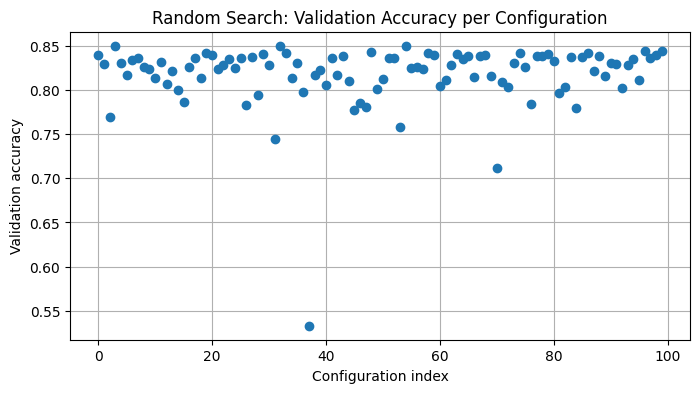

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(search_results["val_accuracy"].values, marker="o", linestyle="none")
plt.xlabel("Configuration index")
plt.ylabel("Validation accuracy")
plt.title("Random Search: Validation Accuracy per Configuration")
plt.grid(True)
plt.show()

In [9]:
best_config = search_results.sort_values(
    by="val_accuracy", ascending=False
).iloc[0]

best_config

hidden_layers    [256, 128]
dropout_rate       0.113619
learning_rate      0.001286
activation             relu
batch_size              128
val_accuracy       0.849833
Name: 3, dtype: object

In [10]:
best_model = create_fcnn(X_train.shape[1], 10, best_config)
best_model.summary()

Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_353 (Dense)               │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_251 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_354 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_252 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_355 (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=int(best_config["batch_size"]),
    verbose=0
)

In [16]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


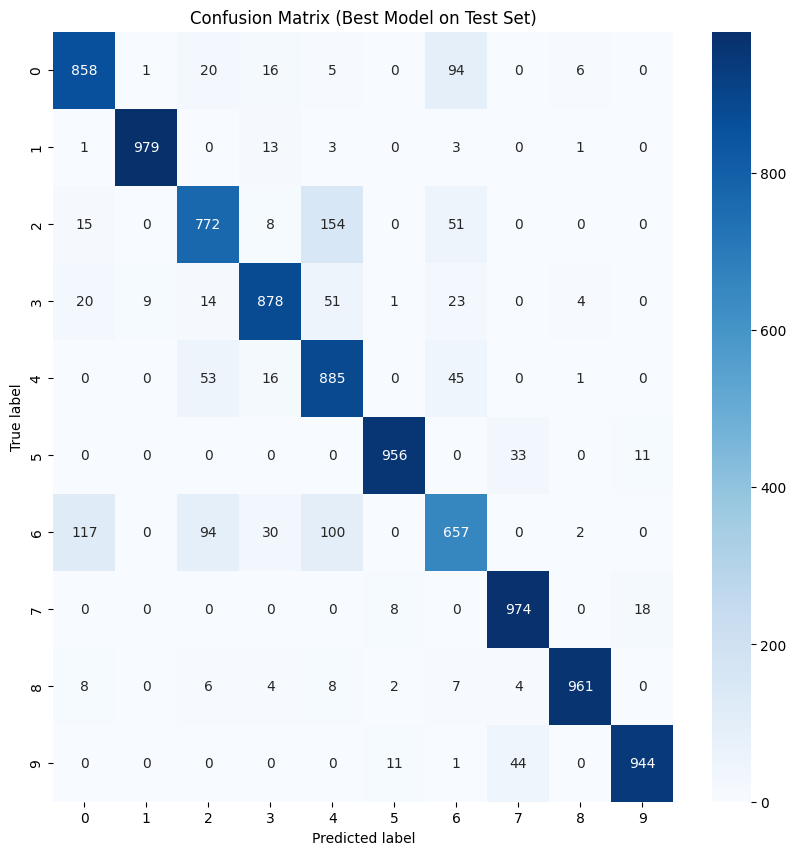

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = best_model.predict(X_test, verbose=0).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Best Model on Test Set)")
plt.show()

### Findings:

- The learning rate had the strongest influence on validation accuracy; very large values often led to unstable training.
- Models using the ELU activation tended to perform slightly better on average than ReLU, especially for deeper architectures.
- Larger batch sizes improved training stability but did not consistently yield higher validation accuracy.
- Moderate dropout values helped prevent overfitting, while very high dropout rates reduced performance.

#### Part b) Fixing the Data Leak (1 point)

**There was a data leak in exercise 9/utils.py, validation was done using:**

```python
model.fit(...., validation_split=0.2)
```

This causes a subtle issue:

* the validation set is created inside `fit()`
* each run (and each random seed) may use a different subset of the training data for validation
* therefore, different hyperparameter configurations are evaluated on different validation data

This makes validation results not directly comparable, which is a form of data leakage -> unfair evaluation.

Additionally, evaluation was sometimes pearformed on parts of the training data, further biasing model selection.


### how it can be fixd?

Simply in 3 steps:
1. Creating a **fixed train/validation split once** using `train_test_split`
2. Passing this split explicitly via `validation_data=(X_val, y_val)`
3. Evaluating **all configurations on the same validation set**

This ensures:
* fair comparison between hyperparameter configurations
* no information from the training data leaks into validation
* validation accuracy is a reliable selection metric

## Exercise 2: Keras Tuner (4 points)

#### Chosen Optimization Strategy: Hyperband

Hyperband is a hyperparameter optimization algorithm based on successive halving.
It allocates a small training budget to many configurations and progressively increases the budget for the most promising ones, while stopping poorly performing configurations early.

Compared to random search, Hyperband uses computational resources more efficiently by avoiding full training of weak configurations, which often leads to faster convergence to good solutions.

In [22]:
%pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [keras_tuner]
Note: you may need to restart the kernel to use updated packages.


In [23]:
import keras_tuner as kt

def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))

    # number of hidden layers
    for i in range(hp.Int("num_layers", 1, 4)):
        units = hp.Choice(f"units_{i}", [64, 128, 256])
        activation = hp.Choice("activation", ["relu", "elu"])

        model.add(tf.keras.layers.Dense(units, activation=activation))
        model.add(tf.keras.layers.Dropout(
            hp.Float("dropout", 0.0, 0.5, step=0.1)
        ))

    model.add(tf.keras.layers.Dense(10, activation="softmax"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float(
                "learning_rate", 1e-4, 1e-2, sampling="log"
            )
        ),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [24]:
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=20,
    factor=3,
    directory="kt_dir",
    project_name="fashion_fcnn"
)

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    verbose=1
)

Trial 30 Complete [00h 01m 05s]
val_accuracy: 0.8928333520889282

Best val_accuracy So Far: 0.8982499837875366
Total elapsed time: 00h 13m 14s


In [25]:
best_hp = tuner.get_best_hyperparameters(1)[0]
best_kt_model = tuner.get_best_models(1)[0]

best_hp.values
best_kt_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,530 (795.04 KB)

 Trainable params: 203,530 (795.04 KB)

 Non-trainable params: 0 (0.00 B)

### Comparison to Random Search

Hyperband reached competitive validation accuracy with fewer fully trained configurations compared to the random search in Exercise 1.
However, with sufficient trials and manual tuning, random search can achieve similar final performance.

Thus, Hyperband is more resource-efficient, but not inherently superior in terms of achievable model quality.